[View in Colaboratory](https://colab.research.google.com/github/kintarou/django-starter/blob/master/time_series_analysis_pytorch.ipynb)

In [1]:
!pip install torch

    100% |████████████████████████████████| 484.0MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b00c000 @  0x7f7cd0afd1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8


In [0]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data (1).csv


In [7]:
dat = pd.read_csv('data.csv', skiprows=[0,1,2,4], encoding='shift-jis')
dat

,年月日,平均気温(℃),平均気温(℃).1,平均気温(℃).2
0,2011/1/1,1.8,8,1
1,2011/1/2,0.4,8,1
2,2011/1/3,-2.3,8,1
3,2011/1/4,-0.8,8,1
4,2011/1/5,1.0,8,1
5,2011/1/6,-1.7,8,1
6,2011/1/7,-3.8,8,1
7,2011/1/8,-0.9,8,1
8,2011/1/9,-1.8,8,1
9,2011/1/10,-3.4,8,1


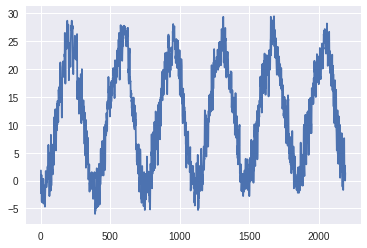

In [8]:
temp = dat['平均気温(℃)']
temp.plot()
plt.show()

In [0]:
train_x = temp[:1461]
test_x = temp[1461:]
train_x = np.array(train_x)
test_x = np.array(test_x)

In [14]:
ATTR_SIZE = 180
tmp = []
train_x = []
for i in range(0, len(train_x) - ATTR_SIZE):
  tmp.append(train_x[i:i+ATTR_SIZE])
train_X = np.array(tmp)
pd.DataFrame(train_X)

,0


In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(180, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 128)
    self.fc4 = nn.Linear(128, 180)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
  
model = Net()  
    

In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(1000):
  total_loss = 0
  d = []
  for i in range(100):
    index = np.random.randint(0, 1281)
    d.append(train_X[index])
    
  d = np.array(d, type="float32")
  d = Variable(torch.from_numpy(d))
  optimizer.zero_grad()
  output = model(d)
  loss = criterion(output, d)
  loss.backward()
  optimizer.step()
  total_loss += loss.data[0]
  
  if (epoch+1)%100 == 0:
    print(epoch+1, total_loss)

In [19]:
plt.plot(d.data[0].numpy(), label ='original')
plt.plot(output.data[0].numpy(), label = 'output')
plt.legend(loc = 'upper right')
plt.show()

AttributeError: ignored